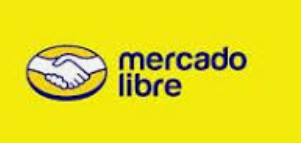

# 1.- Business Understanding

--Contexto General--

-Mercado Libre posee operaciones en múltiples países en Latinoamerica, sirviendo desde diversos warehouses y fulfillment centers. Actualmente procesamos más de 50 ordenes por segundo.
Con el fin de cumplir las expectativas de nuestros clientes, necesitamos tener un forecast de demanda lo más preciso posible para tener el stock adecuado en cada ciudad y llegar lo antes posible donde nuestros compradores.

--Objetivo y Naturaleza del Problema--

El objetivo es generar un forecast semanal de demanda a nivel de `product_id` para cada ciudad para los próximos 3 días desde la última venta del archivo `product_sales`. Es decir que si por ejemplo el último día de ventas fue el 8 de agosto de 2024, se debe entregar forecast para el 9, 10 y 11 de agosto de 2024. Donde el forecast del 9 de agosto equivale a las ventas proyectadas desde el 9 al 15 (1 semana) y así sucesivamente.

# 2.- Data Understanding

La comprensión de datos es la segunda fase del proceso estándar intersectorial para la minería de datos (CRISP-DM) y es un paso crítico en el proceso de minería de datos. Esta fase tiene como objetivo familiarizar al analista de datos con los datos y garantizar que los datos sean adecuados para el objetivo previsto.

## 2.1- Descarga de Librerias

In [1]:
import time
start_time = time.time()

In [2]:
!pip install xgboost > NUL 2>&1
!pip install prophet > NUL 2>&1
!pip install pandasql > NUL 2>&1
!pip install tensorflow > NUL 2>&1
!pip install lightgbm > NUL 2>&1
!pip install optuna > NUL 2>&1

In [3]:
import pandas as pd # pandas: Manipulación y análisis de datos
import matplotlib.pyplot as plt # matplotlib.pyplot: Creación de gráficos estáticos
import seaborn as sns # seaborn: Visualización de datos basada en matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose # statsmodels.tsa.seasonal: Descomposición estacional de series temporales
from statsmodels.tsa.stattools import adfuller # statsmodels.tsa.stattools: Prueba de raíz unitaria ADF para verificar la estacionariedad de una serie temporal
from sklearn.model_selection import train_test_split # sklearn.model_selection: División de datos en conjuntos de entrenamiento y prueba
from sklearn.neighbors import KNeighborsRegressor # sklearn.neighbors: Implementación del algoritmo K-Nearest Neighbors para regresión
from sklearn.metrics import mean_squared_error # sklearn.metrics: Cálculo de métricas de rendimiento como el error cuadrático medio (MSE)
import numpy as np # numpy: Manipulación de arreglos y funciones matemáticas
from sklearn.neural_network import MLPRegressor # sklearn.neural_network: Implementación de perceptrones multicapa para regresión
from sklearn.ensemble import RandomForestRegressor # sklearn.ensemble: Implementación de algoritmos de ensemble como Random Forest para regresión
import xgboost as xgb # xgboost: Implementación del algoritmo de Gradient Boosting para regresión
from sklearn.ensemble import AdaBoostRegressor # sklearn.ensemble: Implementación del algoritmo de AdaBoost para regresión
from sklearn.model_selection import GridSearchCV # sklearn.model_selection: Búsqueda en cuadrícula para ajuste de hiperparámetros
from sklearn.metrics import mean_absolute_error # sklearn.metrics: Cálculo de métricas de rendimiento como el error absoluto medio (MAE)
from statsmodels.tsa.arima.model import ARIMA # statsmodels.tsa.arima.model: Implementación del modelo ARIMA para series temporales
!pip install pmdarima # Instalación de la librería pmdarima para análisis de series temporales
import pmdarima as pm # pmdarima: Automatización del modelado ARIMA para series temporales
from sklearn.metrics import mean_squared_error, mean_absolute_error # sklearn.metrics: Cálculo de métricas de rendimiento como el error cuadrático medio (MSE) y el error absoluto medio (MAE)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## 2.2 Descarga de los Datos

Se descargan todos los datos necesarios para poder ejecutar el dasafio técnico

In [4]:
product_sales_df = pd.read_csv('./product_sales.csv')

In [5]:
print("Q de columnas: ", product_sales_df.shape[1])
print("Q de filas: ", product_sales_df.shape[0])
print("Q distintos de product_id: ", product_sales_df['product_id'].nunique())
print("Q distintos de zipcode: ", product_sales_df['zipcode'].nunique())
print("Q de valores nulos: ",product_sales_df.isnull().any())
print(product_sales_df.isnull().sum())

# Contar filas duplicadas
q_duplicated_rows = product_sales_df.duplicated().sum()
print("Q de filas duplicadas: ", q_duplicated_rows)


Q de columnas:  5
Q de filas:  227355
Q distintos de product_id:  990
Q distintos de zipcode:  72316
Q de valores nulos:  country       False
product_id    False
date          False
zipcode        True
sales          True
dtype: bool
country         0
product_id      0
date            0
zipcode       808
sales          41
dtype: int64
Q de filas duplicadas:  83665


In [6]:
product_sales_df = product_sales_df.drop_duplicates(keep='first')

**Supuesto 1:**

En el proceso de análisis de datos, se identificaron valores atípicos en la variable sales, específicamente los valores '9999' y 'xfffx'. Estos valores fueron considerados atípicos debido a su desviación significativa respecto a otros valores en el conjunto de datos y a la naturaleza inconsistente del valor xfffx, que no corresponde a un formato numérico válido.

Imputar estos valores podría introducir sesgos o errores en el análisis, ya que tales métodos podrían no reflejar adecuadamente la realidad subyacente de los datos. La media, mediana o moda, al no estar basadas en el contexto específico de estos valores atípicos, podrían distorsionar la distribución y las conclusiones derivadas del análisis.


La eliminación de estos outliers es, en este caso, la medida más adecuada para preservar la integridad del análisis.

In [7]:
product_sales_df = product_sales_df[product_sales_df['sales'] != '9999' ]
product_sales_df = product_sales_df[product_sales_df['sales'] != 'xfffx']

In [8]:
print("Q de columnas: ", product_sales_df.shape[1])
print("Q de filas: ", product_sales_df.shape[0])
print("Q distintos de product_id: ", product_sales_df['product_id'].nunique())
print("Q distintos de zipcode: ", product_sales_df['zipcode'].nunique())
print("Q de valores nulos: ",product_sales_df.isnull().any())
print(product_sales_df.isnull().sum())

# Contar filas duplicadas
q_duplicated_rows = product_sales_df.duplicated().sum()
print("Q de filas duplicadas: ", q_duplicated_rows)

Q de columnas:  5
Q de filas:  118452
Q distintos de product_id:  984
Q distintos de zipcode:  62728
Q de valores nulos:  country       False
product_id    False
date          False
zipcode        True
sales          True
dtype: bool
country         0
product_id      0
date            0
zipcode       424
sales          27
dtype: int64
Q de filas duplicadas:  0


In [9]:
#Calulando los valores missings de Tabla Shoppers
total = product_sales_df.isnull().sum().sort_values(ascending=False)
percent = round((product_sales_df.isnull().sum() / product_sales_df.isnull().count() * 100), 2)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent (%)'])
missing_values

,Total,Percent (%)
zipcode,424,0.36
sales,27,0.02
country,0,0.00
date,0,0.00
product_id,0,0.00


**Supuesto 2:**

Se eliminan desde el dataframe product_sales_df aquellos nulos de zipcode y sales, cabe recordad que la variable "sales" es nuestra variable a predecir "Y" por lo tanto no puede llevar nulos dentro de su contenido

In [10]:
product_sales_df = product_sales_df.dropna(subset=['sales','zipcode'])

In [11]:
# - country: País asociado a la orden.
# - s_zipcode: Zipcode de inicio para el rango.
# - e_zipcode: Zipcode de fin para el rango.
# - city: Ciudad desde la que se sirve un producto.
geo_df = pd.read_csv('./geo.csv')
geo_df.head(5)

,country,s_zipcode,e_zipcode,city
0,B,63700000,63740000,B1
1,B,57968000,57980000,B1
2,B,46966970,46970000,B1
3,B,44600000,44640000,B1
4,B,49670000,49700000,B1


## 2.2 Analisis exploratorio de los datos

In [12]:
print("Q de columnas: ", geo_df.shape[1])
print("Q de filas: ", geo_df.shape[0])
print("Q distintos de s_zipcode: ", geo_df['s_zipcode'].nunique())
print("Q distintos de e_zipcode: ", geo_df['e_zipcode'].nunique())
print("Q de valores nulos: ",geo_df.isnull().any())
# Contar filas duplicadas
q_duplicated_rows =  geo_df.duplicated().sum()
print("Q de filas duplicadas: ", q_duplicated_rows)

Q de columnas:  4
Q de filas:  10805
Q distintos de s_zipcode:  10802
Q distintos de e_zipcode:  10803
Q de valores nulos:  country      False
s_zipcode    False
e_zipcode    False
city         False
dtype: bool
Q de filas duplicadas:  0


En la celda de más abajo se valida despues de la eliminación de datos atipicos si lleva solo numericos que es lo esperable dentro de esta categoria


In [13]:
import pandas as pd

# Contar valores numéricos y no numéricos en 'sales'
num_count = product_sales_df['sales'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notnull().sum()
non_num_count = product_sales_df['sales'].apply(lambda x: pd.to_numeric(x, errors='coerce')).isnull().sum()

# Mostrar los resultados
print(f"Valores numéricos en 'sales': {num_count}")
print(f"Valores no numéricos en 'sales': {non_num_count}")

Valores numéricos en 'sales': 118001
Valores no numéricos en 'sales': 0


En la celda de más abajo el objetivo es visualizar como es la tendencia de ventas diarias en todo el dataframe lo que nos dice el 86 porciento de las ventas diarias por Product Id corresponde solo a 1 venta

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por el valor de 'sales' y contar las ocurrencias
sales_count = product_sales_df['sales'].value_counts().reset_index()
sales_count.columns = ['sales', 'count']

# Convertir la columna 'sales' a numérica, eliminando valores no numéricos
sales_count['sales'] = pd.to_numeric(sales_count['sales'], errors='coerce')
sales_count = sales_count.dropna()

# Ordenar los valores de sales
sales_count = sales_count.sort_values(by='count', ascending=False)

# Calcular el porcentaje del total
total_count = sales_count['count'].sum()
sales_count['percentage'] = (sales_count['count'] / total_count * 100).round(2)

# Mostrar el DataFrame resultante
sales_count.head(5)


,sales,count,percentage
0,1.0,102494,86.86
1,2.0,9543,8.09
2,3.0,2951,2.50
3,4.0,1336,1.13
4,5.0,552,0.47


## 2.3 Procesamiento de datos y Featuring Engineering

**Comentarios:**

El código de más abajo es muy importante porque nos permite obtener en product_id asociado a una ciudad especifica que está relacionado a lo que se espera dentro del análisis que se asjunta a continuación, se usa pysql para hacer la consulta más rapida en pandas tomo mucho tiempo de procesamiento

In [15]:
import pandas as pd
import pandasql as psql
import datetime

# Paso 1: Optimizar el tipo de dato de los códigos postales
geo_df['s_zipcode'] = geo_df['s_zipcode'].astype('int32')
geo_df['e_zipcode'] = geo_df['e_zipcode'].astype('int32')
# Convertir la columna 'sales' a float primero y luego a int, truncando los valores
product_sales_df['sales'] = product_sales_df['sales'].astype(float).astype(int)


# Si no usas Dask, este paso sigue igual con pandas
# Definir la consulta SQL
query = """
SELECT *
FROM product_sales_df AS p
INNER JOIN geo_df AS g
on (p.country = g.country) and (p.zipcode >= g.s_zipcode AND p.zipcode <= g.e_zipcode)
"""

# Ejecutar la consulta con pandasql
merged_df = psql.sqldf(query, locals())

# # Paso 5: Liberar memoria de los DataFrames originales si ya no los necesitas
# del product_sales_df, geo_df

# Muestra un ejemplo de los primeros 10 resultados
# merged_df.head(10)


# Paso 4: Convertir la columna de fecha a tipo datetime
# -----------------------------------------------------
# Convertimos la columna 'date' en un tipo de dato datetime para facilitar la extracción de características temporales.
merged_df['date'] = pd.to_datetime(merged_df['date'], format="%Y-%m-%d")

merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
merged_df=merged_df.groupby(['product_id', 'city', 'date'])['sales'].sum().reset_index()

merged_df.to_csv('./merged_df.csv', index=False)

In [16]:
import pandas as pd

# Asegurarnos de que la columna 'date' esté en formato datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Contar el número de días con ventas (fechas distintas) por `product_id` y `city`
days_with_sales = merged_df.groupby(['product_id', 'city'])['date'].nunique().reset_index()

# Renombrar la columna 'date' a 'days_with_sales'
days_with_sales.columns = ['product_id', 'city', 'days_with_sales']

# Contar el número de product_id distintos por city
unique_products = days_with_sales.groupby('city')['product_id'].nunique().reset_index()
unique_products.columns = ['city', 'unique_product_count']

# Calcular las estadísticas agregadas (máximo, mínimo, promedio, mediana) de los días con ventas
sales_stats = days_with_sales.groupby('city')['days_with_sales'].agg(['max', 'min', 'mean', 'median','std']).reset_index()

# Unir el conteo de productos únicos al DataFrame de estadísticas
final_stats = pd.merge(sales_stats, unique_products, on='city')

# Mostrar el DataFrame con las estadísticas finales
print(final_stats)

  city  max  min       mean  median        std  unique_product_count
0   B1   66    1  10.067982     5.0  12.762487                   456
1   B2   67    1   9.194748     4.0  11.747496                   457
2   B3   68    1  24.744604    19.0  19.156620                   556
3   M1   38    1   5.595041     3.0   6.277905                   242
4   M2   66    1  13.977636     9.0  13.952856                   313
5   M3   68    1  21.718182    15.5  18.365323                   330
6   M4   64    1  12.310580     8.0  12.833328                   293
7   M5   51    1   6.752033     3.0   8.008127                   246


La celda de más arriba nos dice mucho, porque despues de hacer el cruce nos dice **cual es la distribucion por product_id, ciudad de dias con venta,

Si revisamos el maximo de fechas con ventas para B1 es 66 y la minima es 1 , lo que llama la tenciuon es que la media es 10 y la mediana es 5, lo que nos dice que en promedio para b1 tenemos 5 dias con ventas con la combinacion product_id ciudad,

En base a los datos recolectados para todos los Product_id, ciudad no se efectuan ventas todos los dias, siendo la que tiene mayor proporción B3

In [17]:
# Contar el número de días con ventas (fechas distintas) solo por `product_id`
days_with_sales_no_city = merged_df.groupby('product_id')['date'].nunique().reset_index()

# Renombrar la columna 'date' a 'days_with_sales'
days_with_sales_no_city.columns = ['product_id', 'days_with_sales']

# Calcular las estadísticas agregadas (máximo, mínimo, promedio, mediana) de los días con ventas sin la ciudad
sales_stats_no_city = days_with_sales_no_city['days_with_sales'].agg(['max', 'min', 'mean', 'median', 'std']).reset_index()

# Mostrar el DataFrame con las estadísticas finales excluyendo la ciudad
print("\nEstadísticas excluyendo la ciudad:")
print(sales_stats_no_city)


Estadísticas excluyendo la ciudad:
    index  days_with_sales
0     max        68.000000
1     min         1.000000
2    mean        27.429844
3  median        22.000000
4     std        19.679825


**Comentarios:**
La media y la mediana del archivo genetado es 27 y 22 respectivamente es decir que en promedio con intervalo inferior de 1 dia y superior de 68 tenemos 27 dias con ventas (sin considerar la ciudad)

## 2.3 Determinación de punto de corte en función de distribución de product_id y city

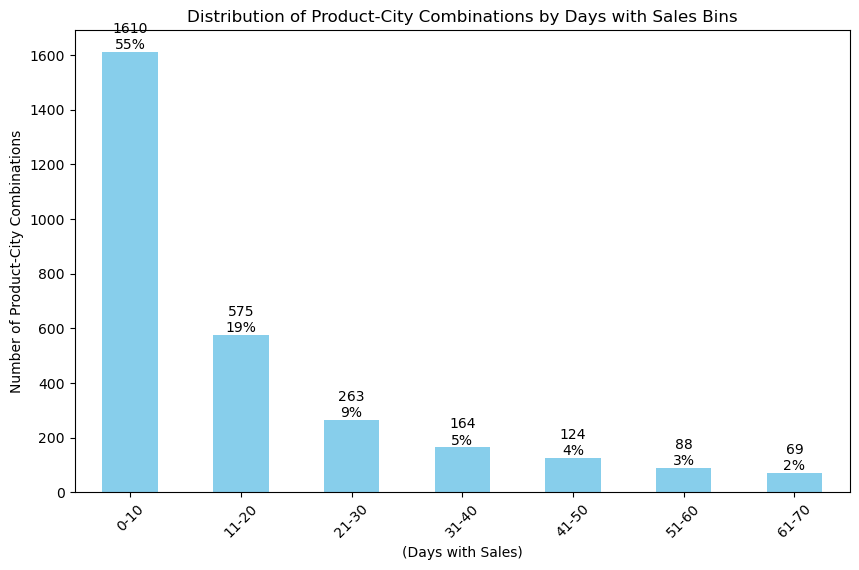

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarnos de que la columna 'date' esté en formato datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Contar el número de días con ventas (fechas distintas) por `product_id` y `city`
days_with_sales = merged_df.groupby(['product_id', 'city'])['date'].nunique().reset_index()
days_with_sales.columns = ['product_id', 'city', 'days_with_sales']

# Definir los bins (intervalos)
bins = [0, 10, 20, 30, 40, 50, 60, 70]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70']

# Asignar los bins a cada combinación product_id-city
days_with_sales['binned_days'] = pd.cut(days_with_sales['days_with_sales'], bins=bins, labels=labels, right=False)

# Contar cuántos product_id-city caen en cada bin
bin_counts = days_with_sales['binned_days'].value_counts().sort_index()

# Visualizar los bins con cantidades y porcentajes
plt.figure(figsize=(10, 6))
bars = bin_counts.plot(kind='bar', color='skyblue')

# Añadir los valores y porcentajes encima de las barras
total = bin_counts.sum()
for bar in bars.patches:
    count = int(bar.get_height())
    percentage = int((count / total) * 100)
    bars.annotate(f'{count}\n{percentage}%',
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Product-City Combinations by Days with Sales Bins')
plt.xlabel('(Days with Sales)')
plt.ylabel('Number of Product-City Combinations')
plt.xticks(rotation=45)
plt.show()

**Comentarios**

La funcion del grafico anterior es ilustrar la distribucion de cominacion product_id, ciudad con fechas para poder realizar las Predicciones

un 55% tienen entre 0 y 10 fechas distintas con ventas y el 45% restante con mas de 10 fechas distintas con ventas

In [19]:
import pandas as pd

# Asegurarnos de que la columna 'date' esté en formato datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Contar el número de días con ventas (fechas distintas) por `product_id` y `city`
days_with_sales = merged_df.groupby(['product_id', 'city'])['date'].nunique().reset_index()
days_with_sales.columns = ['product_id', 'city', 'days_with_sales']

# Filtrar las combinaciones de product_id y city que tengan al menos 10 días de ventas distintas
filtered_days_with_sales = days_with_sales[days_with_sales['days_with_sales'] >= 20]

# Hacer un merge con el DataFrame original para mantener solo las combinaciones que cumplen con el criterio
merged_df = pd.merge(merged_df, filtered_days_with_sales[['product_id', 'city']], on=['product_id', 'city'])

In [20]:
import pandas as pd

# Asegurarnos de que la columna 'date' esté en formato datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Contar el número de días con ventas (fechas distintas) por `product_id` y `city`
days_with_sales = merged_df.groupby(['product_id', 'city'])['date'].nunique().reset_index()
days_with_sales.columns = ['product_id', 'city', 'days_with_sales']

# Filtrar las combinaciones de product_id y city que tengan al menos 10 días de ventas distintas
filtered_days_with_sales = days_with_sales[days_with_sales['days_with_sales'] >= 20]

# Hacer un merge con el DataFrame original para mantener solo las combinaciones que cumplen con el criterio
merged_df= pd.merge(merged_df, filtered_days_with_sales[['product_id', 'city']], on=['product_id', 'city'])

**Comentarios**


**SUPUESTO 3:** en el documento de desafio no se manifiesta si hay ciudades o Product_ids **estrategicos que Mercado Libre** que no se puedan eliminar, por lo tanto se asume que todos tienen el mismo peso,


En el grafico anterior se dejó como minimo **20** ventas para poder poder tener predicciones mas certeras y se detemino ese valor porque es cercano a la media que es **27** de ventas por product_id y mediana **22**

Se asume que solo se predicira con un 26% de todos los product_id ciudad seleccionados, pero con más represantativos con más h historial de ventas se podrian hacer predicciones mas cercanas a la realidad

## 2.4 Creacion de nuevas variables predictoras

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Asegurarnos de que la columna 'date' esté en formato datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Ordenar los datos por product_id, city y fecha
merged_df = merged_df.sort_values(by=['product_id', 'city', 'date'])


# Características de la fecha
merged_df['day_of_week'] = merged_df['date'].dt.weekday
merged_df['day_is_weekend'] = np.where(merged_df['day_of_week'].isin([5, 6]), 1, 0)
merged_df['day_of_year'] = merged_df['date'].dt.dayofyear
merged_df['day_of_month'] = merged_df['date'].dt.day
merged_df['week_of_year'] = merged_df['date'].dt.isocalendar().week
merged_df['sales_lag_1'] = merged_df.groupby(['product_id', 'city'])['sales'].shift(1)
merged_df['sales_lag_14'] = merged_df.groupby(['product_id', 'city'])['sales'].shift(14)
merged_df['sales_lag_21'] = merged_df.groupby(['product_id', 'city'])['sales'].shift(21)
merged_df['sales_lag_28'] = merged_df.groupby(['product_id', 'city'])['sales'].shift(28)
merged_df['sales_rolling_sum_21'] = merged_df.groupby(['product_id', 'city'])['sales'].rolling(window=21).sum().reset_index(drop=True)
merged_df['sales_rolling_sum_28'] = merged_df.groupby(['product_id', 'city'])['sales'].rolling(window=28).sum().reset_index(drop=True)
merged_df['sales_rolling_max_42'] = merged_df.groupby(['product_id', 'city'])['sales'].rolling(window=42).max().reset_index(drop=True)
merged_df['sales_rolling_min_42'] = merged_df.groupby(['product_id', 'city'])['sales'].rolling(window=42).min().reset_index(drop=True)
merged_df['sales_rolling_max_49'] = merged_df.groupby(['product_id', 'city'])['sales'].rolling(window=49).max().reset_index(drop=True)
merged_df['sales_rolling_min_49'] = merged_df.groupby(['product_id', 'city'])['sales'].rolling(window=49).min().reset_index(drop=True)
merged_df['sales_rolling_max_56'] = merged_df.groupby(['product_id', 'city'])['sales'].rolling(window=56).max().reset_index(drop=True)
merged_df['sales_rolling_min_56'] = merged_df.groupby(['product_id', 'city'])['sales'].rolling(window=56).min().reset_index(drop=True)
merged_df.fillna(0, inplace=True)

2024-08-13 19:45:01.840098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 19:45:01.857807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 19:45:01.862647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 19:45:01.876859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 19:45:02.998295: W tensorflow/comp

**Comentarios**
En este apartado se generan nuevas variables para mejorar performance de la predicción

# 3.- Modelamiento

## 3.1 Separacion entre Entrenamiento y Test

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import optuna
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Crear una columna combinada de `product_id` y `city`
merged_df['product_city'] = merged_df['product_id'].astype(str) + '_' + merged_df['city'].astype(str)

# Ordenar los datos por `product_id`, `city`, y `date`
merged_df = merged_df.sort_values(by=['product_id', 'city', 'date'])

# Separar características (X) y la variable objetivo (y)
X = merged_df.drop(columns=['sales', 'date', 'product_id', 'city', 'product_city'])
y = merged_df['sales']
dates = merged_df['date']

# Crear un objeto para la división asegurando que cada `product_city` esté en un solo conjunto
splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Realizar la división asegurando que no haya solapamiento de `product_city`
for train_idx, test_idx in splitter.split(X, y, groups=merged_df['product_city']):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    dates_train, dates_test = dates.iloc[train_idx], dates.iloc[test_idx]

# Verificar que no haya solapamiento entre los conjuntos de entrenamiento y prueba en términos de `product_city`
train_product_city = set(merged_df['product_city'].iloc[train_idx])
test_product_city = set(merged_df['product_city'].iloc[test_idx])

# Asegúrate de que no haya intersección entre los conjuntos
assert train_product_city.isdisjoint(test_product_city), "Hay solapamiento entre los conjuntos de entrenamiento y prueba en términos de `product_city`."

# Si no hay errores, entonces la separación es correcta y puedes proceder
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Asegurarnos de que las columnas en X_train y X_test son las mismas
X_test = X_test[X_train.columns]

**Comentarios**

El código prepara un conjunto de datos merged_df, creando una nueva columna combinada de product_id y city, y lo ordena por esas variables y por date. Posteriormente, divide los datos en conjuntos de entrenamiento y prueba utilizando GroupShuffleSplit, asegurando que no haya solapamiento entre los conjuntos en términos de la combinación product_city.

Al final rellena los valores faltantes en los conjuntos de datos de entrenamiento y prueba y asegura la consistencia de las columnas entre ambos conjuntos antes de proceder con el modelado.

## 3.2 Mapa de Correlaciones en entrenamiento

<Axes: title={'center': 'Pearson Correlation of Features'}>

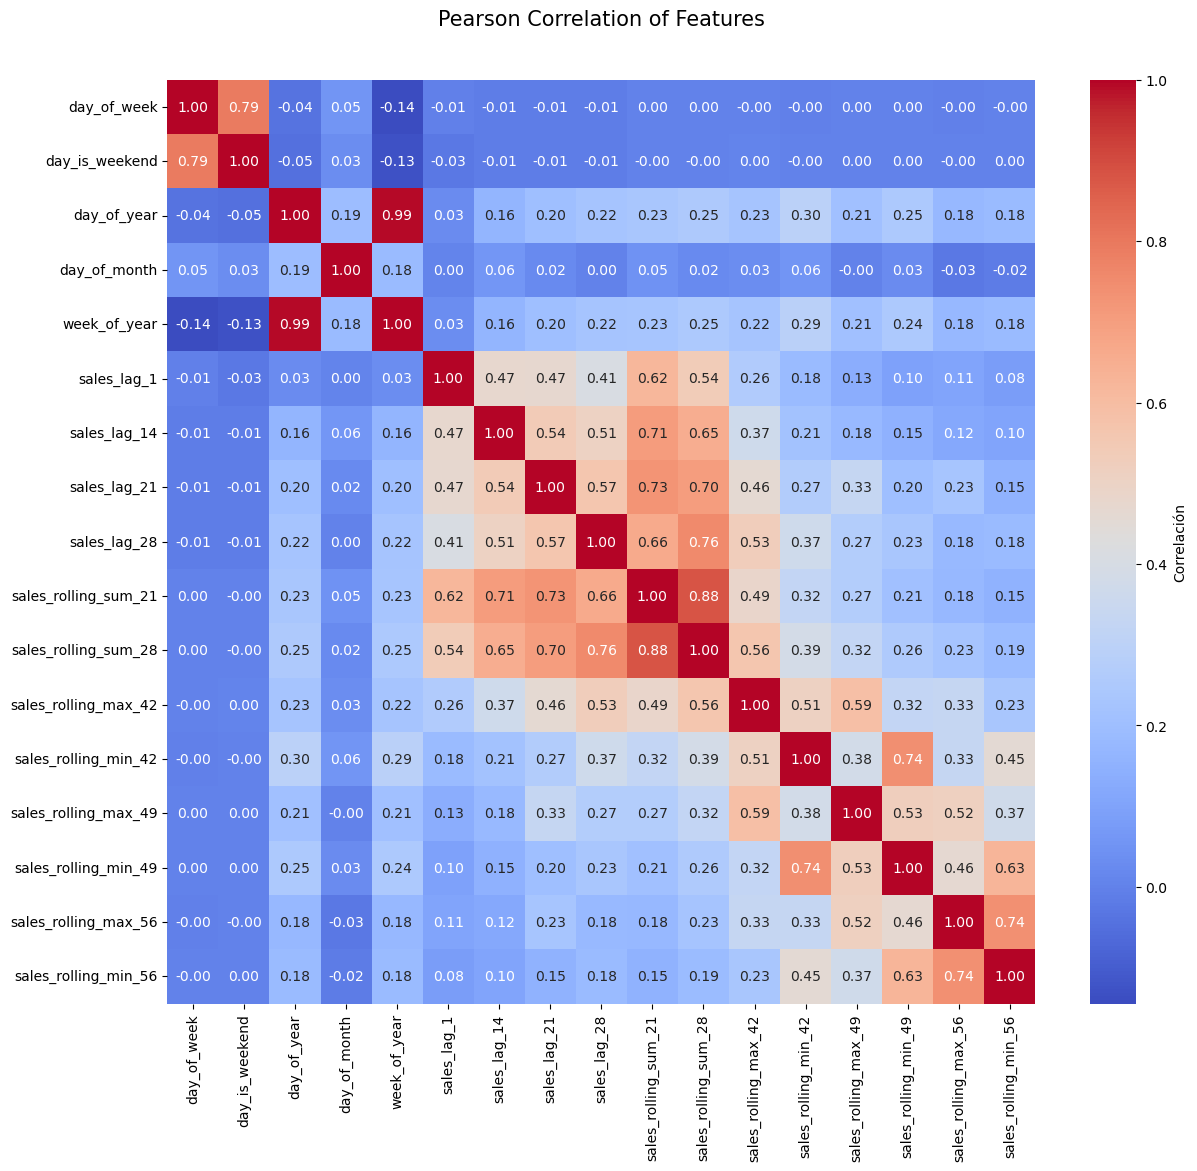

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asumiendo que 'correlation_matrix' es tu matriz de correlación
correlation_matrix = X_train.corr()
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)

# Agrega anotaciones para mostrar los valores de correlación
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlación'})

**Comentarios**

El mapa de correlaciones utiliza colores para representar estos valores, facilitando la identificación visual de relaciones fuertes o débiles entre las variables. Es una herramienta útil en análisis de datos para entender cómo las variables están interrelacionadas y para seleccionar variables relevantes para modelos predictivos.

## 3.3 Evaluación de todos los modelos (usando series temporales) en train y test

In [24]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

class ModelEvaluation:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = {}
        self.metrics = {}
        print("Inicialización completa")

    def train_sarima(self):
        print("Entrenando SARIMA...")
        sarima_model = SARIMAX(self.y_train, order=(2, 1, 2), seasonal_order=(2, 1, 2, 7))
        sarima_model_fit = sarima_model.fit(disp=False)
        sarima_predictions = sarima_model_fit.get_forecast(steps=len(self.y_test)).predicted_mean
        self.models["SARIMA"] = sarima_predictions
        print("SARIMA entrenado y predicciones generadas.")

    def train_arima(self):
        print("Entrenando ARIMA...")
        arima_model = ARIMA(self.y_train, order=(5, 1, 4))
        arima_model_fit = arima_model.fit()
        arima_predictions = arima_model_fit.get_forecast(steps=len(self.y_test)).predicted_mean
        self.models["ARIMA"] = arima_predictions
        print("ARIMA entrenado y predicciones generadas.")

    def train_random_forest(self):
        print("Entrenando Random Forest...")
        rf_model = RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(self.X_train, self.y_train)
        rf_predictions = rf_model.predict(self.X_test)
        self.models["Random Forest"] = rf_predictions
        print("Random Forest entrenado y predicciones generadas.")

    def train_lightgbm(self):
        print("Training LightGBM model...")
        lgb_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 31,
            'learning_rate': 0.01,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'lambda_l1': 0.3,
            'lambda_l2': 0.3,
            'min_data_in_leaf': 10,
            'num_threads': 4,
            'max_depth': 10,
            'early_stopping_round': 50,
            'num_iterations': 1000
        }

        train_data = lgb.Dataset(self.X_train, label=self.y_train)
        valid_data = lgb.Dataset(self.X_test, label=self.y_test)

        lgb_model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=500,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(25)]
        )
        lgb_predictions = lgb_model.predict(self.X_test)
        self.models["LightGBM"] = lgb_predictions
        print("LightGBM entrenado y predicciones generadas.")

    def train_lstm(self):
        print("Entrenando LSTM...")
        def create_sequences(X, y, time_steps=1):
            Xs, ys = [], []
            for i in range(len(X) - time_steps):
                Xs.append(X[i:(i + time_steps)])
                ys.append(y[i + time_steps])
            return np.array(Xs), np.array(ys)

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_X_train = scaler.fit_transform(self.X_train)
        scaled_X_test = scaler.transform(self.X_test)

        X_train_seq, y_train_seq = create_sequences(scaled_X_train, self.y_train.values, time_steps=7)
        X_test_seq, y_test_seq = create_sequences(scaled_X_test, self.y_test.values, time_steps=7)

        lstm_model = Sequential()
        lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(LSTM(units=50, return_sequences=False))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(units=20))
        lstm_model.add(Dense(units=1))

        lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error')
        lstm_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=128, verbose=0)

        lstm_predictions = lstm_model.predict(X_test_seq)
        lstm_predictions = lstm_predictions.flatten()  # Asegúrate de que las predicciones sean unidimensionales
        self.models["LSTM"] = lstm_predictions
        print("LSTM entrenado y predicciones generadas.")

    def train_mlp(self):
        print("Entrenando MLP Regressor...")
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_X_train = scaler.fit_transform(self.X_train)
        scaled_X_test = scaler.transform(self.X_test)

        mlp_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
        mlp_model.fit(scaled_X_train, self.y_train)
        mlp_predictions = mlp_model.predict(scaled_X_test)
        self.models["MLP Regressor"] = mlp_predictions
        print("MLP Regressor entrenado y predicciones generadas.")

    def train_adaboost(self):
        print("Entrenando AdaBoost Regressor...")
        adaboost_model = AdaBoostRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
        adaboost_model.fit(self.X_train, self.y_train)
        adaboost_predictions = adaboost_model.predict(self.X_test)
        self.models["AdaBoost Regressor"] = adaboost_predictions
        print("AdaBoost Regressor entrenado y predicciones generadas.")

    def _calculate_metrics(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)
        return mae, rmse, mape

    def calculate_metrics(self):
        print("Calculando métricas para cada modelo...")
        for model_name, predictions in self.models.items():
            # Asegurar que las longitudes coincidan
            min_len = min(len(self.y_test), len(predictions))
            y_true = self.y_test[:min_len]
            y_pred = predictions[:min_len]

            mae, rmse, mape = self._calculate_metrics(y_true, y_pred)
            self.metrics[model_name] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}
            print(f"{model_name} -> MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")

    def run(self):
        print("Inicio del proceso de entrenamiento de modelos...")
        self.train_sarima()
        self.train_arima()
        self.train_random_forest()
        self.train_lightgbm()
        self.train_lstm()
        self.train_mlp()
        self.train_adaboost()
        self.calculate_metrics()
        print("Proceso completado.")

# Uso de la clase ModelEvaluation
evaluator = ModelEvaluation(X_train, X_test, y_train, y_test)
evaluator.run()

Inicialización completa
Inicio del proceso de entrenamiento de modelos...
Entrenando SARIMA...
SARIMA entrenado y predicciones generadas.
Entrenando ARIMA...
ARIMA entrenado y predicciones generadas.
Entrenando Random Forest...
Random Forest entrenado y predicciones generadas.
Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 18727, number of used features: 17
[LightGBM] [Info] Start training from score 5.205799
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early 

2024-08-13 19:46:36.850687: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM entrenado y predicciones generadas.
Entrenando MLP Regressor...
MLP Regressor entrenado y predicciones generadas.
Entrenando AdaBoost Regressor...
AdaBoost Regressor entrenado y predicciones generadas.
Calculando métricas para cada modelo...
SARIMA -> MAE: 3.8596666030500937, RMSE: 7.202697976030223, MAPE: 0.9081945989591299
ARIMA -> MAE: 3.073521327268761, RMSE: 6.2740195711510856, MAPE: 1.0068884080574312
Random Forest -> MAE: 2.4462063647634125, RMSE: 4.407701924825964, MAPE: 0.9716909174399504
LightGBM -> MAE: 2.459055311588308, RMSE: 4.33942504776503, MAPE: 1.0023690979549966
LSTM -> MAE: 2.3217120384348875, RMSE: 4.376608443263988, MAPE: 0.7533540344753012
MLP Regressor -> MAE: 2.588296764176712, RMSE: 4.393662014815852, MAPE: 1.0917802396800396
AdaBoost Regressor -> MAE: 5.977032546072806, RMSE: 12.317830131000553, MAPE: 3.2679756987773847
Proceso completado.


**Comentarios**

**Se optó por entrenar y testear ventas diarias, porque no existe suficiente información histórica de ventas por
product_id, ciudad (media 27 y mediana 22 dias distintos con ventas) lo que hace que calcular directamente semanal haga mas dificil, el pronostico, razon por la cual con la venta diaria se predecira venta semanal**

Este código entrena y evalúa varios modelos de predicción utilizando diferentes algoritmos, como SARIMA, ARIMA, Random Forest, LightGBM, LSTM, MLP Regressor, y AdaBoost, sobre un conjunto de datos de entrenamiento (X_train, y_train) y prueba (X_test, y_test).

Después de entrenar cada modelo, se generan predicciones y se calculan métricas de rendimiento (MAE, RMSE, MAPE) para cada uno. Finalmente, se muestran estas métricas para comparar el rendimiento de los modelos.



**Al final se eligió LightGBM por:**

Rendimiento Sólido en Métricas Clave: LightGBM tiene un RMSE (4.34) y MAE (2.46) comparables a los mejores modelos, como Random Forest. Aunque Random Forest tiene un RMSE ligeramente mejor, la diferencia es mínima, lo que hace que LightGBM sea una excelente opción en términos de precisión.

Eficiencia y Velocidad: LightGBM está diseñado para ser extremadamente rápido y eficiente en términos de tiempo de entrenamiento y predicción, especialmente con grandes volúmenes de datos. Esto es útil si estás manejando conjuntos de datos grandes o si necesitas realizar muchas iteraciones de entrenamiento

## 3.4 Visualización del mejor modelo para cada product_id y ciudad

Inicialización completa
Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 18727, number of used features: 17
[LightGBM] [Info] Start training from score 5.205799
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[245]	valid_0's rmse: 4.33943
LightGBM entrenado y predicciones generadas.


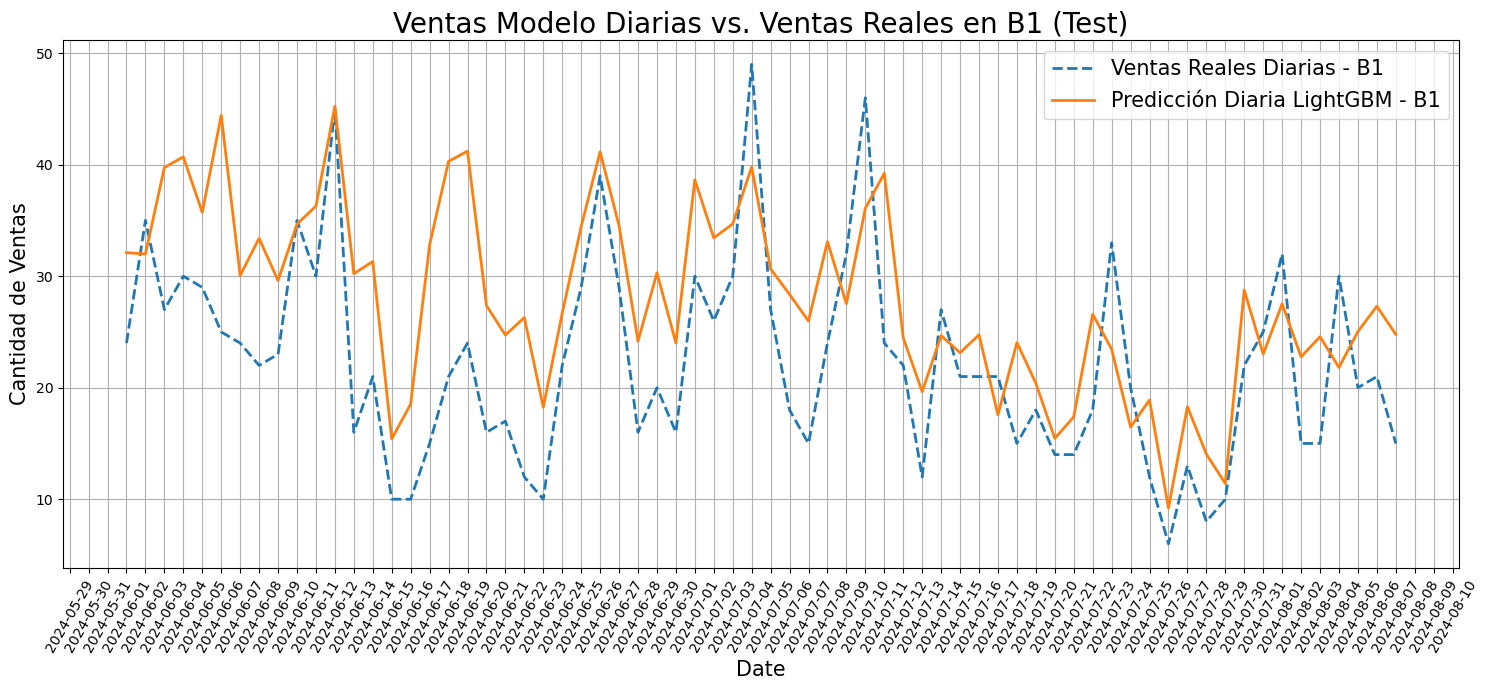

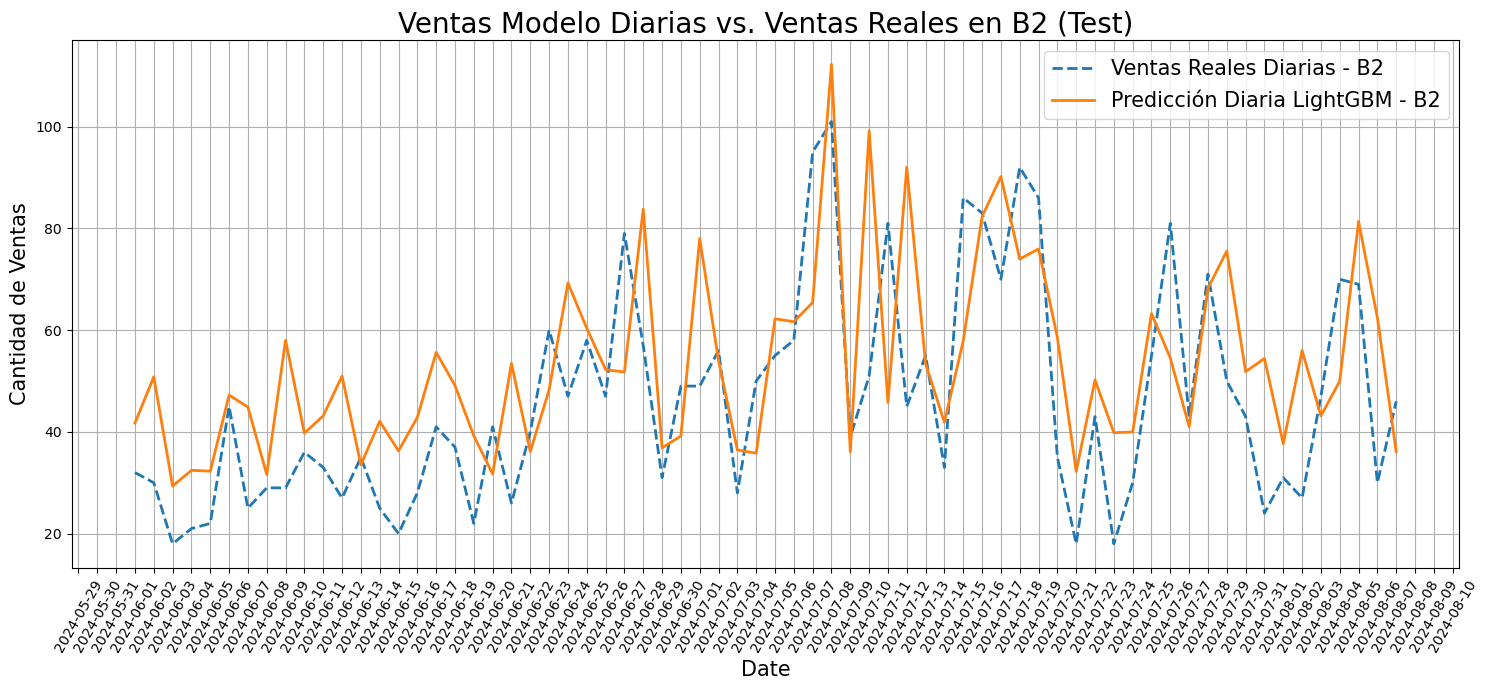

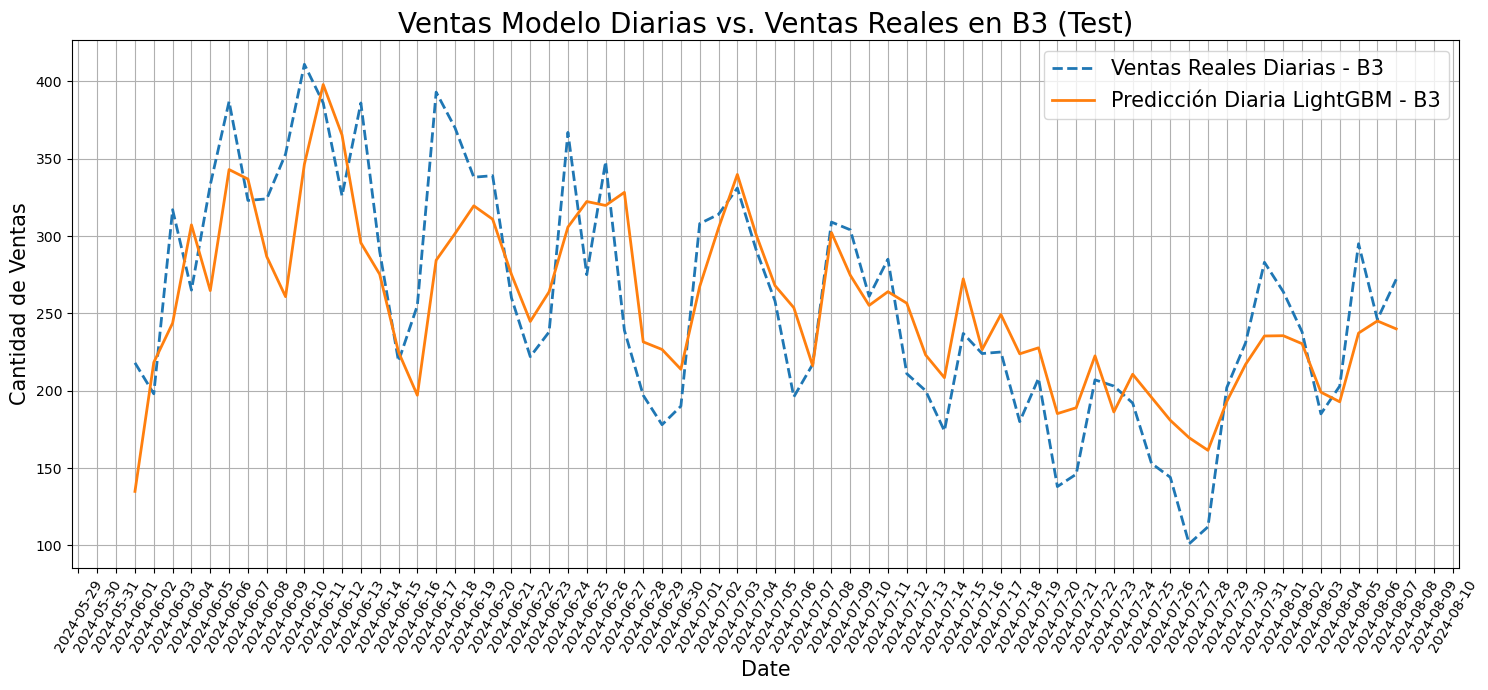

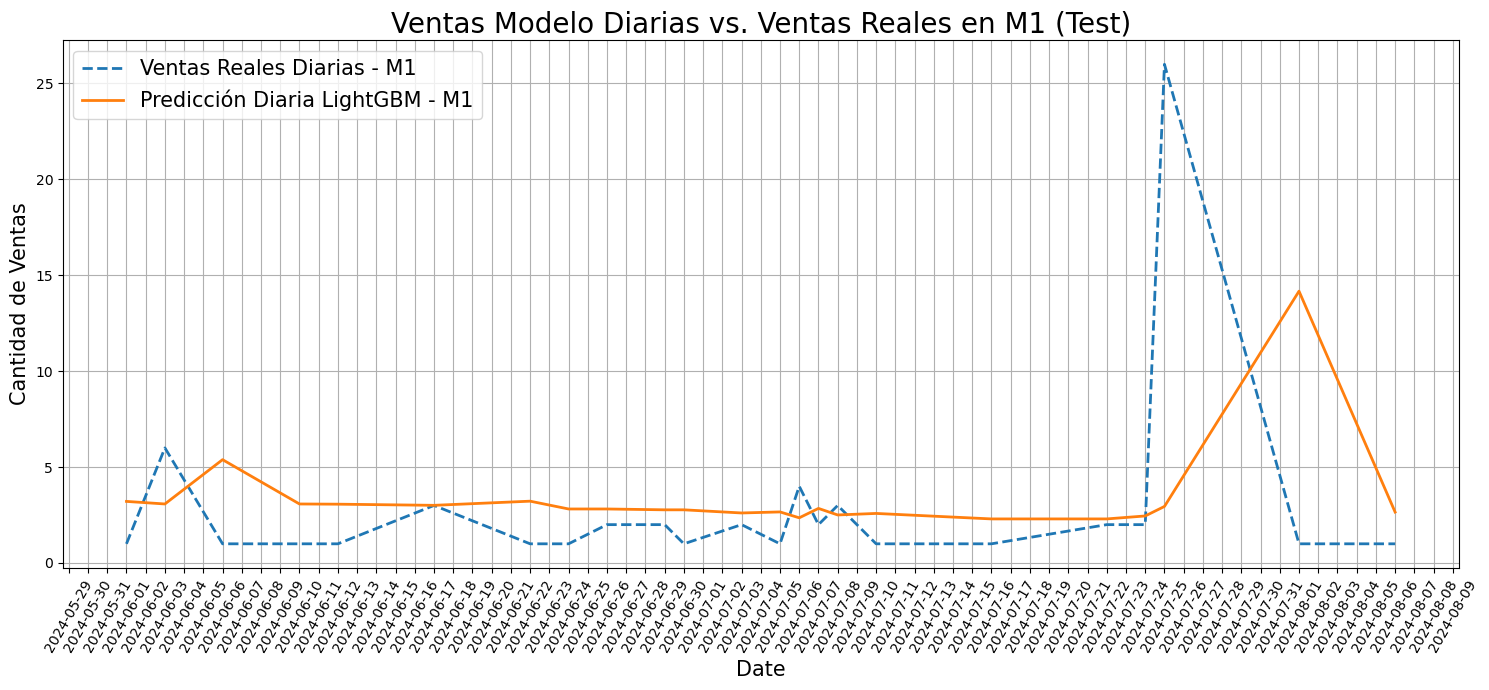

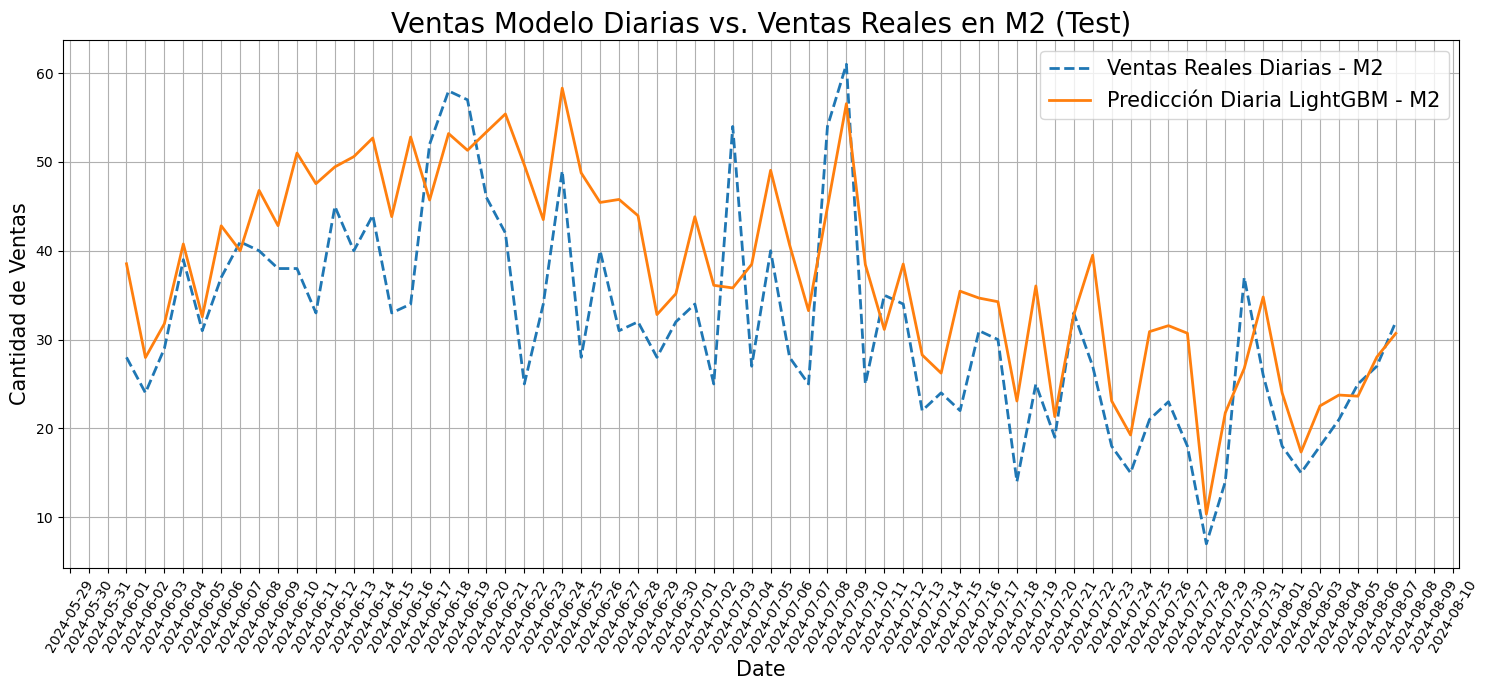

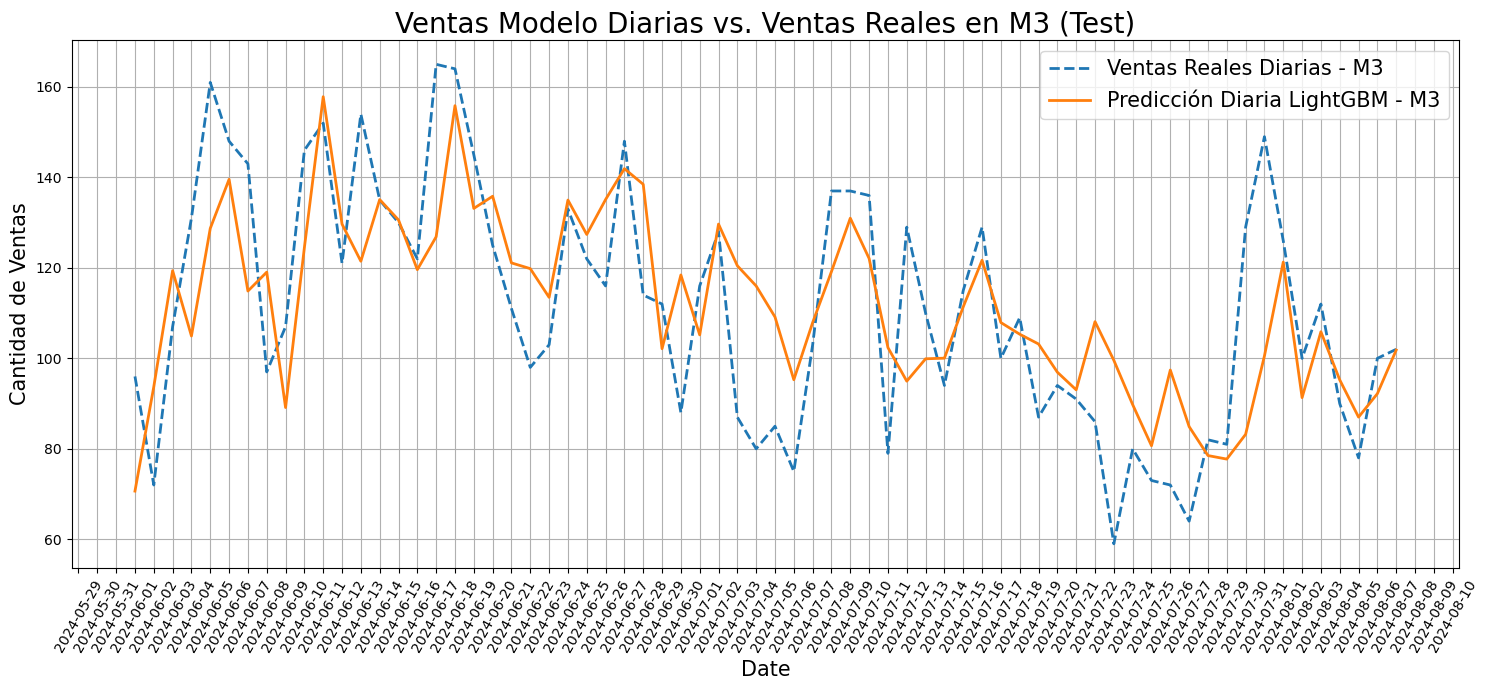

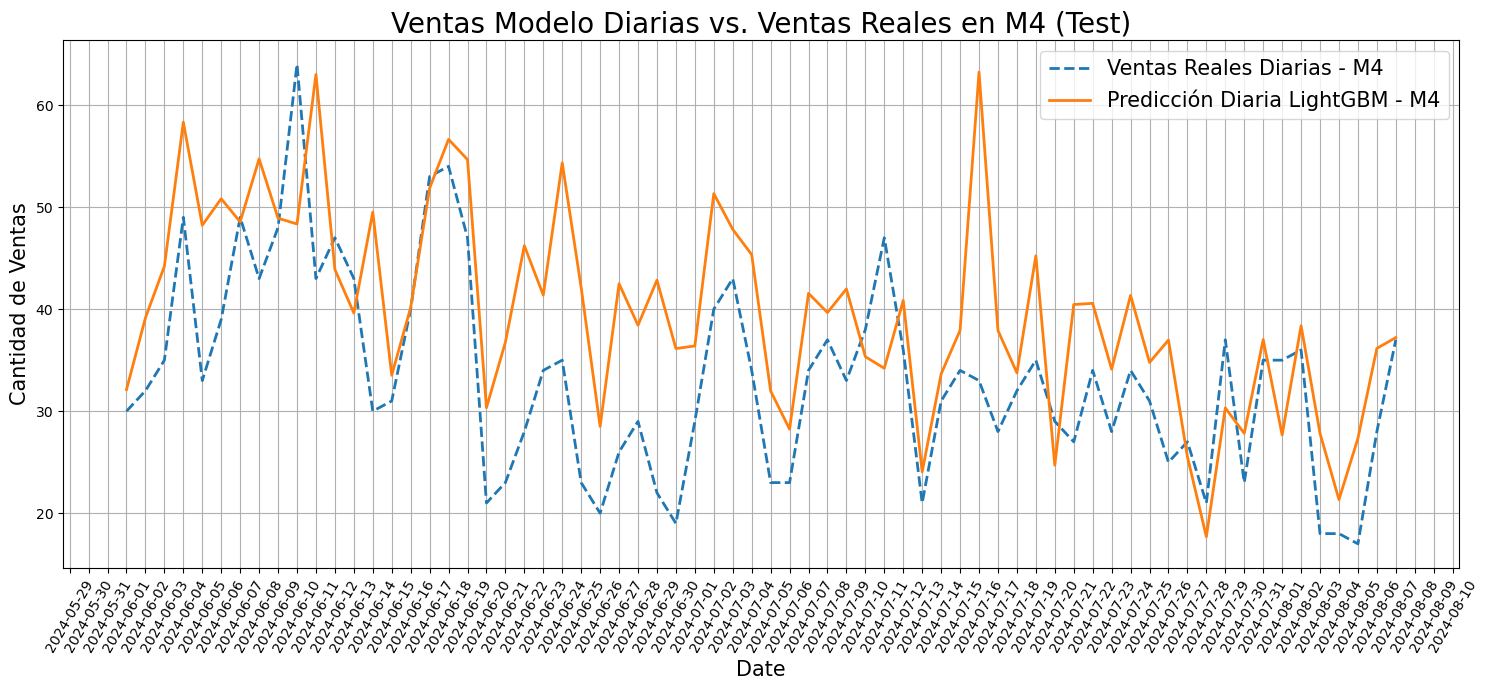

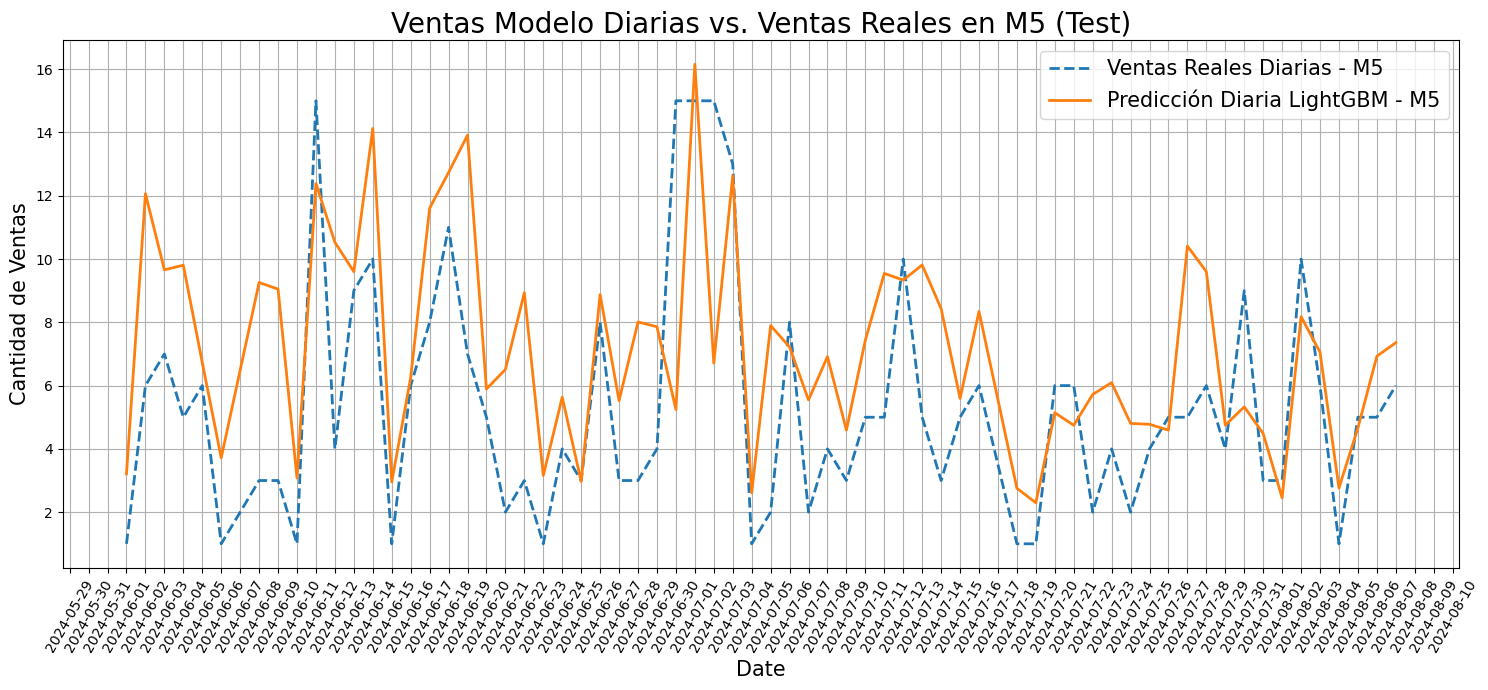

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit

# Crear una instancia de la clase ModelEvaluation y entrenar el modelo MLP
evaluator = ModelEvaluation(X_train, X_test, y_train, y_test)
evaluator.train_lightgbm()

# Obtener las predicciones en el conjunto de prueba
lightGBM_predictions = evaluator.models["LightGBM"]

# Crear una columna combinada de `product_id` y `city`
merged_df['product_city'] = merged_df['product_id'].astype(str) + '_' + merged_df['city'].astype(str)

# Ordenar los datos por `product_id`, `city`, y `date`
merged_df = merged_df.sort_values(by=['product_id', 'city', 'date'])

# Separar características (X) y la variable objetivo (y)
X = merged_df.drop(columns=['sales', 'date', 'product_id', 'city', 'product_city'])
y = merged_df['sales']
dates = merged_df['date']

# Crear un objeto para la división asegurando que cada `product_city` esté en un solo conjunto
splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Realizar la división asegurando que no haya solapamiento de `product_city`
for train_idx, test_idx in splitter.split(X, y, groups=merged_df['product_city']):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    dates_test = dates.iloc[test_idx]
    cities_test = merged_df['city'].iloc[test_idx]
    product_ids_test = merged_df['product_id'].iloc[test_idx]

# Convertir las predicciones y las ventas reales a DataFrames, agregando los IDs correspondientes
pred_df = pd.DataFrame({
    'date': dates_test.values,
    'city': cities_test.values,
    'product_id': product_ids_test.values,
    'lightGBM_predictions': lightGBM_predictions
})

y_test_df = pd.DataFrame({
    'date': dates_test.values,
    'city': cities_test.values,
    'product_id': product_ids_test.values,
    'sales': y_test.values
})

# Agregar las predicciones y las ventas reales por `date`, `city`, y `product_id`
comparison_df = pd.merge(y_test_df, pred_df, on=['date', 'city', 'product_id'], how='inner')

# Agrupar los datos por fecha y ciudad, sumando las ventas reales y las predicciones
aggregated_sales = comparison_df.groupby(['date', 'city']).agg({'sales': 'sum', 'lightGBM_predictions': 'sum'}).reset_index()

# Crear gráficos separados por ciudad
import matplotlib.dates as mdates

# Asumiendo que `aggregated_sales` ya ha sido generado con predicciones diarias
for city in aggregated_sales['city'].unique():
    city_data = aggregated_sales[aggregated_sales['city'] == city]

    plt.figure(figsize=(15, 7))
    plt.plot(city_data['date'], city_data['sales'], label=f"Ventas Reales Diarias - {city}", linestyle='--', linewidth=2)
    plt.plot(city_data['date'], city_data['lightGBM_predictions'], label=f"Predicción Diaria LightGBM - {city}", linestyle='-', linewidth=2)

    # Configurar títulos y etiquetas
    plt.title(f"Ventas Modelo Diarias vs. Ventas Reales en {city} (Test)", fontsize=20)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Cantidad de Ventas", fontsize=15)
    plt.legend(prop={'size':15})

    # Configurar la frecuencia de las etiquetas del eje X para que sean diarias
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotar etiquetas de fecha
    plt.xticks(rotation=60)
    plt.grid(True)
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

**Comentarios**


Este código genera gráficos que comparan las ventas reales diarias con las predicciones diarias generadas por el modelo LightGBM para diferentes ciudades.

Para cada ciudad, el gráfico muestra cómo las ventas reales (representadas por una línea discontinua) se comparan con las ventas predichas por el modelo LightGBM (representadas por una línea continua).


# 4 Forecast de Modelo

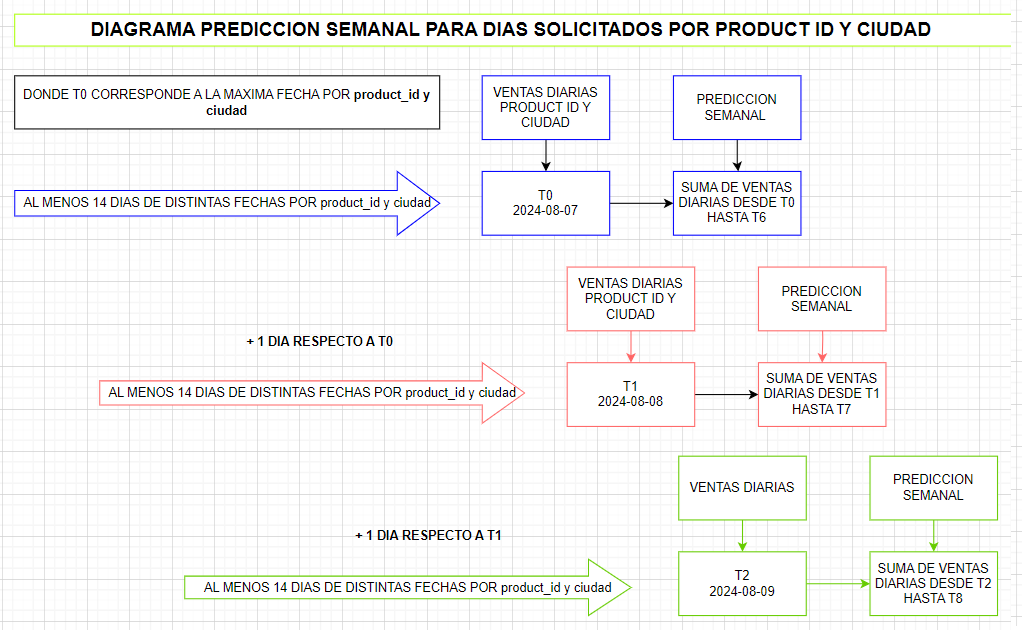

In [26]:
import warnings
import pandas as pd
import numpy as np
from datetime import timedelta
import lightgbm as lgb
import time

# Ignorar ciertas advertencias
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

class ModelEvaluation:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.lgb_model = None

    def train_lightgbm(self):
        """Entrena el modelo LightGBM"""
        print("Training LightGBM model...")
        lgb_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 31,
            'learning_rate': 0.01,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'lambda_l1': 0.3,
            'lambda_l2': 0.3,
            'min_data_in_leaf': 10,
            'num_threads': 4,
            'max_depth': 10,
            'early_stopping_round': 50,
            'num_iterations': 1000
        }

        train_data = lgb.Dataset(self.X_train, label=self.y_train)
        valid_data = lgb.Dataset(self.X_test, label=self.y_test)

        self.lgb_model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=300,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(25)]
        )
        print("Model training complete.")

    def predict(self, X_input):
        """Realiza predicciones usando el modelo entrenado"""
        return self.lgb_model.predict(X_input.select_dtypes(exclude=['datetime', 'datetime64']))

    @staticmethod
    def create_lag_features(df, lag_days):
        """Crea características de retraso (lags) en el DataFrame"""
        for lag in lag_days:
            df[f'sales_lag_{lag}'] = df.groupby(['product_id', 'city'])['sales'].shift(lag)
        return df

    @staticmethod
    def calculate_rolling_features(df):
        """Calcula características de rolling (promedios, máximos, mínimos) para el DataFrame"""
        rolling_windows = [7, 35, 42, 49]
        for window in rolling_windows:
            df[f'sales_rolling_max_{window}'] = df['sales'].rolling(window=window).max()
            df[f'sales_rolling_min_{window}'] = df['sales'].rolling(window=window).min()
        df['sales_rolling_mean_28'] = df['sales'].rolling(window=28).mean()
        return df

    def generate_weekly_forecast(self, df):
        """Genera pronósticos semanales basados en el modelo entrenado"""
        print("Generating weekly forecasts...")
        lag_days = [1, 7, 14, 21, 28]
        df = self.create_lag_features(df.copy(), lag_days)

        predictions = []
        for (product_id, city), group in df.groupby(['product_id', 'city']):
            historical_data = group[group['date'] <= group['date'].max()]
            historical_data = self.calculate_rolling_features(historical_data)

            for i in range(3):
                forecast_date = group['date'].max() + timedelta(days=i+1)
                weekly_sales_sum = self.predict_weekly_sales(historical_data, forecast_date)

                predictions.append({
                    'product_id': product_id,
                    'city': city,
                    'date': forecast_date.strftime('%Y-%m-%d'),
                    'sales': weekly_sales_sum
                })

                # Actualizar los datos históricos con la predicción realizada
                historical_data = self.update_historical_data(historical_data, forecast_date, weekly_sales_sum)

        print("Weekly forecasts generation complete.")
        return pd.DataFrame(predictions)

    def predict_weekly_sales(self, historical_data, forecast_date):
        """Predice ventas semanales basado en los datos históricos y la fecha de pronóstico"""
        weekly_sales_sum = 0
        for day in range(7):  # Sumar ventas proyectadas para los próximos 7 días
            future_date = forecast_date + timedelta(days=day)
            X_input = self.prepare_input_data(historical_data, future_date)
            weekly_sales_sum += self.predict(X_input)[0]
        return weekly_sales_sum

    def update_historical_data(self, historical_data, forecast_date, prediction):
        """Actualiza los datos históricos con la nueva predicción"""
        new_data = pd.DataFrame({
            'date': [forecast_date],
            'sales': [prediction],
            'product_id': historical_data['product_id'].iloc[-1],
            'city': historical_data['city'].iloc[-1]
        })
        historical_data = pd.concat([historical_data, new_data], ignore_index=True)
        historical_data = self.create_lag_features(historical_data, [1, 7, 14, 21, 28])
        historical_data = self.calculate_rolling_features(historical_data)
        return historical_data

    @staticmethod
    def prepare_input_data(historical_data, future_date):
        """Prepara los datos de entrada para el modelo de predicción"""
        return pd.DataFrame({
            'day_of_week': [future_date.weekday()],
            'day_is_weekend': [1 if future_date.weekday() >= 5 else 0],
            'week_of_year': [future_date.isocalendar().week],
            'day_of_year': [future_date.timetuple().tm_yday],
            'day_of_month': [future_date.day],
            'sales_lag_1': [historical_data['sales'].iloc[-1]],
            'sales_lag_14': [historical_data['sales'].iloc[-14] if len(historical_data) > 14 else 0],
            'sales_lag_21': [historical_data['sales'].iloc[-21] if len(historical_data) > 21 else 0],
            'sales_lag_28': [historical_data['sales'].iloc[-28] if len(historical_data) > 28 else 0],
            'sales_rolling_sum_21': [historical_data['sales_rolling_mean_28'].iloc[-1] if len(historical_data) >= 21 else 0],
            'sales_rolling_sum_28': [historical_data['sales_rolling_mean_28'].iloc[-1] if len(historical_data) >= 28 else 0],
            'sales_rolling_max_42': [historical_data['sales_rolling_max_42'].iloc[-1] if len(historical_data) >= 42 else 0],
            'sales_rolling_min_42': [historical_data['sales_rolling_min_42'].iloc[-1] if len(historical_data) >= 42 else 0],
            'sales_rolling_max_49': [historical_data['sales_rolling_max_49'].iloc[-1] if len(historical_data) >= 49 else 0],
            'sales_rolling_min_49': [historical_data['sales_rolling_min_49'].iloc[-1] if len(historical_data) >= 49 else 0],
            'sales_rolling_max_56': [historical_data['sales_rolling_max_49'].iloc[-1] if len(historical_data) >= 56 else 0],
            'sales_rolling_min_56': [historical_data['sales_rolling_min_49'].iloc[-1] if len(historical_data) >= 56 else 0]
        })

# Ejecución del código principal
start_time = time.time()
print("Starting execution...")

# Suponiendo que ya tienes X_train, X_test, y_train, y_test cargados
evaluator = ModelEvaluation(X_train, X_test, y_train, y_test)
evaluator.train_lightgbm()

# Generar las predicciones con las variables del futuro
future_predictions_df = evaluator.generate_weekly_forecast(merged_df)

# Guardar las predicciones en un archivo CSV llamado "submission.csv"
submission_file = './submission.csv'
future_predictions_df.to_csv(submission_file, index=False)
print(f"Predictions saved to {submission_file}.")

# Mostrar el DataFrame resultante
future_predictions_df


Starting execution...
Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 18727, number of used features: 17
[LightGBM] [Info] Start training from score 5.205799
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[245]	valid_0's rmse: 4.33943
Model training complete.
Generating weekly forecasts...
Weekly forecasts generation complete.
Predictions saved to ./submission.csv.


,product_id,city,date,sales
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-07-27,22.182439
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-07-28,106.208260
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-07-29,548.863350
3,015ad371-f82f-4eba-ab3a-dc4c77262d23,B3,2024-08-04,22.740734
4,015ad371-f82f-4eba-ab3a-dc4c77262d23,B3,2024-08-05,109.898045
...,...,...,...,...
2119,fed0c486-fcc3-486f-8749-4d28b0de323f,B2,2024-08-09,109.717188
2120,fed0c486-fcc3-486f-8749-4d28b0de323f,B2,2024-08-10,539.843388
2121,fed0c486-fcc3-486f-8749-4d28b0de323f,B3,2024-08-08,37.737433
2122,fed0c486-fcc3-486f-8749-4d28b0de323f,B3,2024-08-09,159.215171


**Comentarios**

A) Para Hacer el forecast se uso se selecciono el modelo que tuvo mejor performance en entrenamiento y prediccion

B) Para consistencia los hiperparametros de forecast son los mismos que cuando se entrenoó/testeo y seleccionó modelo

C) Este código entrena un modelo de LightGBM utilizando datos de entrenamiento (X_train, y_train) y datos de prueba (X_test, y_test).Tras el entrenamiento, el código genera características de retraso (lags) y características de rolling (promedios, máximos, mínimos) para un conjunto de datos, que luego se utilizan para predecir las ventas semanales de un producto en diferentes ciudades para los próximos tres días. Cada día predicho se basa en los valores calculados de días anteriores y las características generadas, las cuales se actualizan con cada nueva predicción.

D) El proceso de predicción se realiza en ciclos, donde para cada ciudad y producto, se predicen las ventas para un período de siete días en el futuro.

E) Estas predicciones se acumulan para formar una proyección de ventas semanal. Al final, las predicciones se almacenan en un archivo CSV llamado submission.csv.

F) Además, el código asegura que las características de rolling y de lags se actualicen después de cada predicción, lo que permite que las predicciones para los días siguientes sean más precisas al tener en cuenta las ventas recién predichas.

**Proximos pasos y recomendaciones**

Literatura y evidencia dice que para hacer predicciones semanales se necesitan al menos 8 semanas para realizar mejores predicciones.

Solicitaría averiguar con expertos acerca de los valores 9999 xffffx en las ventas si es un error o si esas ventas.

En el futuro seria interesante contar con el valor montario del product_id, para saber si hay una correlacion entre precio de venta y cantidad

Con usuarios expertos solicitaria mas data de historia para poder tener mejores predicciones